## [Hugging Face: Basic Task Tutorial for Solving Text Classification Issues](https://www.stxnext.com/blog/hugging-face-tutorial/)

To realize the full potential of NLP, you need to be able to use the latest Transformer architecture—a deep learning model that adopts the mechanism of self-attention, differentially weighting the significance of each part of the input data.
Hugging Face allows you to shorten the distance to the latest NLP solutions and technologies.


### BERT

It started in 2017 with the introduction of the new Transformer architecture, enabling highly complex and powerful NLP models. Thanks to the Attention mechanism, they didn’t suffer from a lack of training parallelism, as was the case with previous RNN modes.

**The BERT model is the encoder part of the Transformer architecture that was trained with the masked language modeling (MLM) and next sentence prediction objective (NSP).**

**The GPT model is a part of the decoder in the Transformer architecture.**

### Loading a dataset

In [1]:
from datasets import load_dataset

ag_news = load_dataset("ag_news")
ag_news

Using custom data configuration default
Reusing dataset ag_news (/home/przemek/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [20]:
ag_news_train = ag_news["train"]
ag_news_test = ag_news["test"]
ag_news_test

Dataset({
    features: ['text', 'label'],
    num_rows: 7600
})

In [21]:
ag_news_test[0]

{'text': "Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.",
 'label': 2}

Way to see the metadata on the elements of the dataset: the “text” property is of the string type while the label is represented as the ClassLabel. It’s a special class that provides the capabilities to manipulate these class labels and map the label integers to their names with the use of the *int2str* method.

In [22]:
print(f"{ag_news_test.column_names}\n{ag_news_test.features}")

['text', 'label']
{'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=4, names=['World', 'Sports', 'Business', 'Sci/Tech'], id=None)}


Check if the dataset is balanced:

In [30]:
print(ag_news["train"].format['type'])

None


In [23]:
ag_news["train"].set_format("pandas")
print(f'{ag_news["train"][:]["label"].apply(lambda x: ag_news_test.features["label"].int2str(x)).value_counts()}')

None
Business    30000
Sports      30000
World       30000
Sci/Tech    30000
Name: label, dtype: int64


Turns out that it’s perfectly balanced, but this is bound to be a rare situation in the future. In other cases, we will have to take some precautions such as data augmentation, oversampling the minority class, or undersampling the majority class.

You should also look at the distribution of sentence lengths across classes. The sentence length will be measured as the number of words in the sentence:

<AxesSubplot:xlabel='label', ylabel='text_len'>

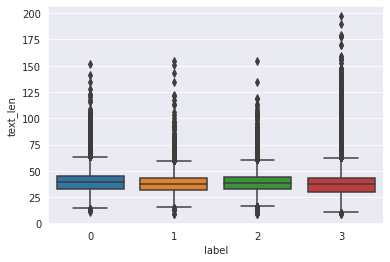

In [6]:
import seaborn as sns

df_ag_news_test = ag_news["test"][:]
df_ag_news_train = ag_news["train"][:]
df_ag_news_train["text_len"] = df_ag_news_train["text"].apply(lambda x: len(x.split(" ")))
sns.boxplot(data=df_ag_news_train, x="label", y="text_len")

The average length of sentences in each class doesn’t exceed 50 words, with extreme values exceeding 200 words in the third class.

Our classifier will be created by tuning the BERT language model. It can accept about 512 tokens (**max_position_embeddings (int, optional, defaults to 512) — The maximum sequence length that this model might ever be used with**), and assuming that each word can be decomposed into about 1.5 tokens, in each case the number of tokens in the sentences will not exceed the maximum number accepted by the model. If there were any outliers that had more than 512 tokens, they could be pruned.

The only real problem that could arise would be if there were many instances where the length after tokenization would exceed the required 512 tokens. In that case, we would have to treat them differently, but that is beyond the scope of this article.

### Text tokenization

**One of the most important parts of the NLP pipeline is the tokenization of text, as the pre-trained models we’ll use were trained on numerical representations.** For this reason, in order to perform the fine-tuning and inference procedure, we need to convert the text to the same representation on which the models were pretrained.

Most modern tokenizers use the subword tokenization technique, which involves splitting words into subword elements, then converting them into identifiers using predefined dictionaries. This ensures that the dictionary isn’t too large, as rare words are modeled with smaller and more common subwords. This approach is good for spelling errors and can be learned from a corpus of data, so common words will be treated as a single token and rare words will be split, making the distribution of tokens in the dataset balanced.

The Hugging Face library implements several different subword tokenizers that come with different models:

* the WordPiece used by the BERT encoder,
* the BPE (Byte-Pair Encoding) used by the RoBERT model,
* the SentencePiece used by the XLM encoder.

**You need to make sure that the tokenizer you use is compatible with the model it was trained on.**

We’ll use the AutoTokenizer class to tokenize the text, which requires a model ID from the Hugging Face Hub or a local path to the model to automatically load the appropriate tokenizer. Since we’ll be using the cased version of the BERT-base model, the code that loads the tokenizer is as follows:

In [2]:
from transformers import AutoTokenizer
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer

PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [3]:
train_tokenized = tokenizer(ag_news["train"]['text'], padding=True, truncation=True)
test_tokenized = tokenizer(ag_news["test"]['text'], padding=True, truncation=True)
print("Tokenized")

Tokenized


The padding parameter determines whether examples will be padded to longer examples from the current batch, while the truncation parameter allows the tokenizer to truncate examples longer than the maximum length, which, in this case, is 512 tokens.

### Training the classifier

The most effective way to train a classifier in NLP is to perform supervised fine-tuning of a pretrained encoder for the downstream task using domain-specific data.
The tokenized text is fed to a pre-trained encoder that returns an array of token embeddings. We get a separate embedding for each token.

So, how do we train the classifier? We can do this in two ways. The first is to **treat the model encoder as a feature extractor**. The second is to **fine-tune the entire model using an attached classifier head**.

#### Feature extractor

In this case, we extract token embeddings from the given text with the use of the pretrained model. We treat the extracted token embeddings as the text representations and train a classifier directly on them.

We don’t change the weights of the encoder. This is a great approach when we don’t have a GPU available, as it’s much less computationally intensive.

#### Fine tuning

Previously, we treated our BERT language model as a feature extractor that created a sentence representation for later use in another machine learning model.

Now, we will attach a dense layer to the BERT language model as a classifier, and during training we’ll update the weight of not only the added layer, but the entire model.

We should create a dataset that can be accepted by the Hugging Face trainer class.

In [4]:
import torch

class Dataset(torch.utils.data.Dataset):

    def __init__(self, texts, labels=None):
        self.encodings = tokenizer(texts, padding=True, truncation=True, max_length=512)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [5]:
train_dataset = Dataset(ag_news["train"]["text"], ag_news["train"]["label"])
test_dataset = Dataset(ag_news["test"]["text"], ag_news["test"]["label"])
print("Datasets created.")

Datasets created.


In [6]:
from transformers import AutoModelForSequenceClassification
model = (AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4).to("cuda"))
print("Model.")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_clas

Model.


Helper function that returns the current performance of our model at the time of evaluation in terms of predefined scores:

In [7]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import numpy as np
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, pos_label='positive', average='weighted')
    precision = precision_score(y_true=labels, y_pred=pred, pos_label='positive', average='weighted')
    f1 = f1_score(y_true=labels, y_pred=pred, pos_label='positive', average='weighted')
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

Now, we need to define the basic parameters of the deep learning process and import a special Trainer class that performs the training, since it has previously implemented all the training loops.

In [8]:
from transformers import TrainingArguments
batch_size = 32
logging_steps = len(ag_news["train"]) // batch_size
model_names = f"{'distilbert-base-uncased'}-fine-tuned-ag-news"
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=100,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    seed=0,
    load_best_model_at_end=True,
    fp16=True)

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


We’re left with initializing a Trainer class with a predefined dataset, model, metrics, and training arguments.

In [9]:
from transformers import Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)


/home/przemek/Deep Learning/road-to-deep-learning/road-to-deep-learning/venv/lib/python3.6/site-packages/transformers/integrations.py:769: FutureWarning: MLflow support for Python 3.6 is deprecated and will be dropped in an upcoming release. At that point, existing Python 3.6 workflows that use MLflow will continue to work without modification, but Python 3.6 users will no longer get access to the latest MLflow features and bugfixes. We recommend that you upgrade to Python 3.7 or newer.
  import mlflow
Using amp half precision backend


In [10]:
trainer.train()
res = trainer.evaluate()
res

/home/przemek/Deep Learning/road-to-deep-learning/road-to-deep-learning/venv/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 120000
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 7500


RuntimeError: CUDA error: CUBLAS_STATUS_EXECUTION_FAILED when calling `cublasGemmEx( handle, opa, opb, m, n, k, &falpha, a, CUDA_R_16F, lda, b, CUDA_R_16F, ldb, &fbeta, c, CUDA_R_16F, ldc, CUDA_R_32F, CUBLAS_GEMM_DFALT_TENSOR_OP)`